In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [31]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/archive/PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

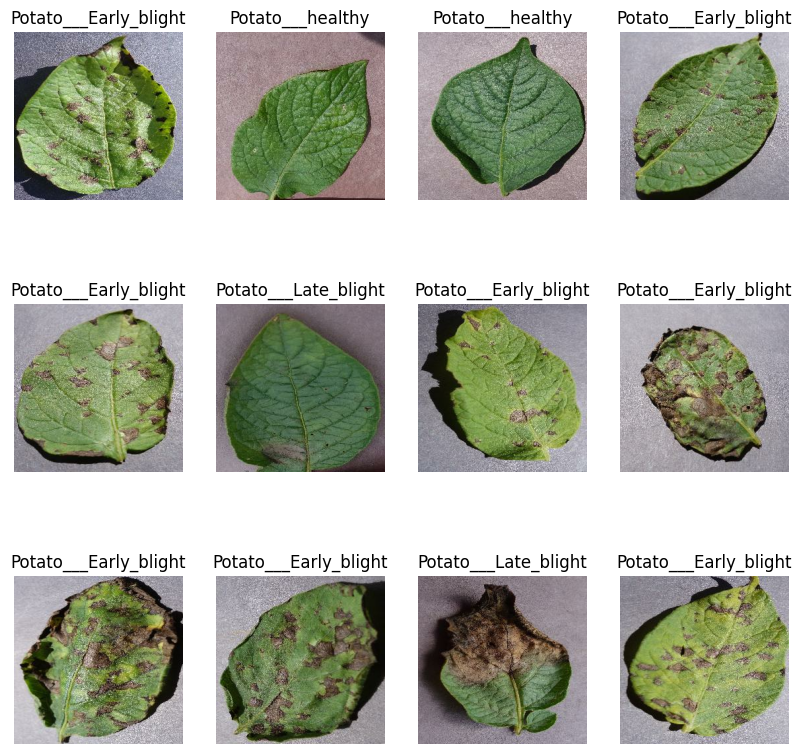

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

In [8]:
def get_dataset_partition(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)

  train_size = int(train_split*ds_size)
  val_size = int(val_split*ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_dataset_partition(dataset)

In [10]:
len(train_ds)

54

In [11]:
len(test_ds)

8

In [15]:
## Caching and prefetching  --> Increase speed of training by running CPU and GPU in parallel

train_ds =  train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds =  val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds =  test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
### Resizing and rescaling

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [17]:
### Data augmentation

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [20]:
### Building model
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 32)          0         
 g2D)                                                 

In [22]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [32]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data = val_ds
)

Epoch 1/50
54/54 [==============================] - 3s 49ms/step - loss: 0.0817 - accuracy: 0.9693 - val_loss: 0.1205 - val_accuracy: 0.9531
Epoch 2/50
54/54 [==============================] - 3s 51ms/step - loss: 0.0794 - accuracy: 0.9670 - val_loss: 0.1467 - val_accuracy: 0.9427
Epoch 3/50
54/54 [==============================] - 3s 50ms/step - loss: 0.0737 - accuracy: 0.9740 - val_loss: 0.2365 - val_accuracy: 0.9323
Epoch 4/50
54/54 [==============================] - 3s 49ms/step - loss: 0.0759 - accuracy: 0.9728 - val_loss: 0.0949 - val_accuracy: 0.9583
Epoch 5/50
54/54 [==============================] - 3s 49ms/step - loss: 0.0636 - accuracy: 0.9757 - val_loss: 0.1870 - val_accuracy: 0.9375
Epoch 6/50
54/54 [==============================] - 3s 53ms/step - loss: 0.0872 - accuracy: 0.9664 - val_loss: 0.1504 - val_accuracy: 0.9531
Epoch 7/50
54/54 [==============================] - 3s 50ms/step - loss: 0.0538 - accuracy: 0.9809 - val_loss: 0.1288 - val_accuracy: 0.9583
Epoch 8/50
54

In [33]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 0s 22ms/step - loss: 0.0399 - accuracy: 0.9805


In [34]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [35]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

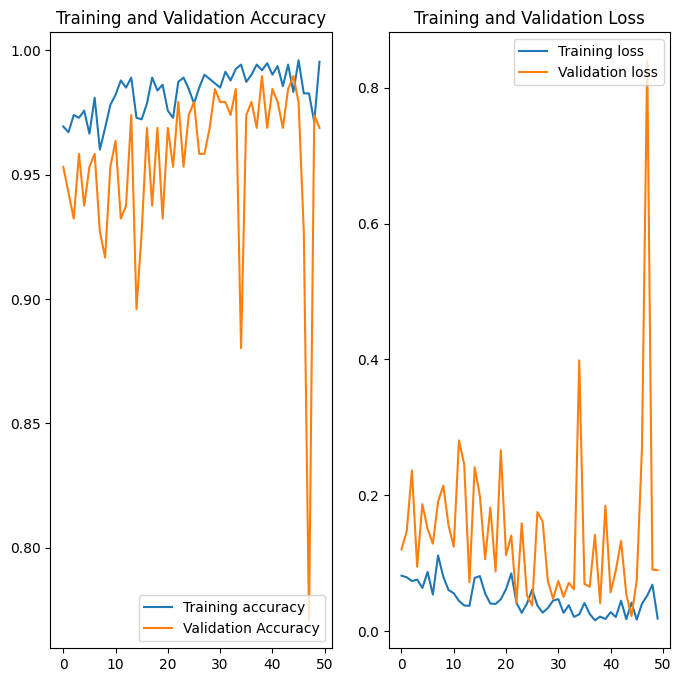

In [37]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label="Training accuracy")
plt.plot(range(EPOCHS), val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label="Training loss")
plt.plot(range(EPOCHS), val_loss, label="Validation loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

1/1 [==============================] - 1s 522ms/step


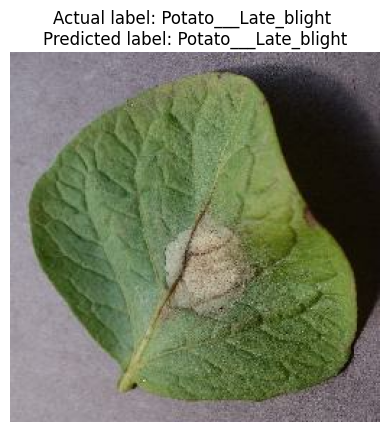

In [40]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
  first_image = images_batch[0].numpy().astype('uint8')
  plt.imshow(first_image)
  plt.axis("off")

  batch_prediction = model.predict(images_batch)
  predicted_label = class_names[np.argmax(batch_prediction[0])]
  plt.title(f"Actual label: {class_names[labels_batch[0].numpy()]} \nPredicted label: {predicted_label}")

In [50]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array,0) # creating a batch
  predictions = model.predict(img_array)
  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100*(np.max(predictions[0])), 2)

  return predicted_class, confidence

In [53]:
plt.figure(figsize=(15,15))

for images, labels in test_ds.take(1):
  for i in range(9):
    plt.subplot(3,3,i+1)
    first_image = images[i].numpy().astype('uint8')
    plt.imshow(first_image)
    plt.axis("off")

    predicted_label, confidence = predict(model, images[i].numpy())
    plt.title(f"Actual label: {class_names[labels[i].numpy()]} \nPredicted label: {predicted_label} \n Confidence: {confidence}")

Output hidden; open in https://colab.research.google.com to view.

In [54]:
model_version=1
model.save(f"/content/drive/MyDrive/archive/models/{model_version}")